# Libraries

In [38]:
import importlib
import strava_data
import strava_data.authentication
import strava_data.visualization
importlib.reload(strava_data)
importlib.reload(strava_data.authentication)
importlib.reload(strava_data.visualization)

from strava_data.authentication import login
import strava_data.visualization as vis
import pandas as pd
import numpy as np

# Login

In [39]:
client = login()

You have already authenticated once before. Refreshing your token now.


No rates present in response headers


Hi Joey, authentication successful!


# Get activities

In [40]:
activities_object = client.get_activities(limit=1000)
activities = list(activities_object)

def get_activity_data(activity):
    activity_dict = dict(activity)
    col_names = ['id','type', 'name', 'distance', 'moving_time', 'elapsed_time',
                 'total_elevation_gain', 'start_date', 'start_latlng', 'kilojoules',
                 'average_heartrate', 'max_heartrate', 'elev_high', 'elev_low',
                 'average_speed', 'max_speed']
    activity_data = {k: activity_dict[k] for k in col_names}
    return activity_data

activities_data = [get_activity_data(a) for a in activities]
df_activities = pd.DataFrame(activities_data)

# Weekly stack plots

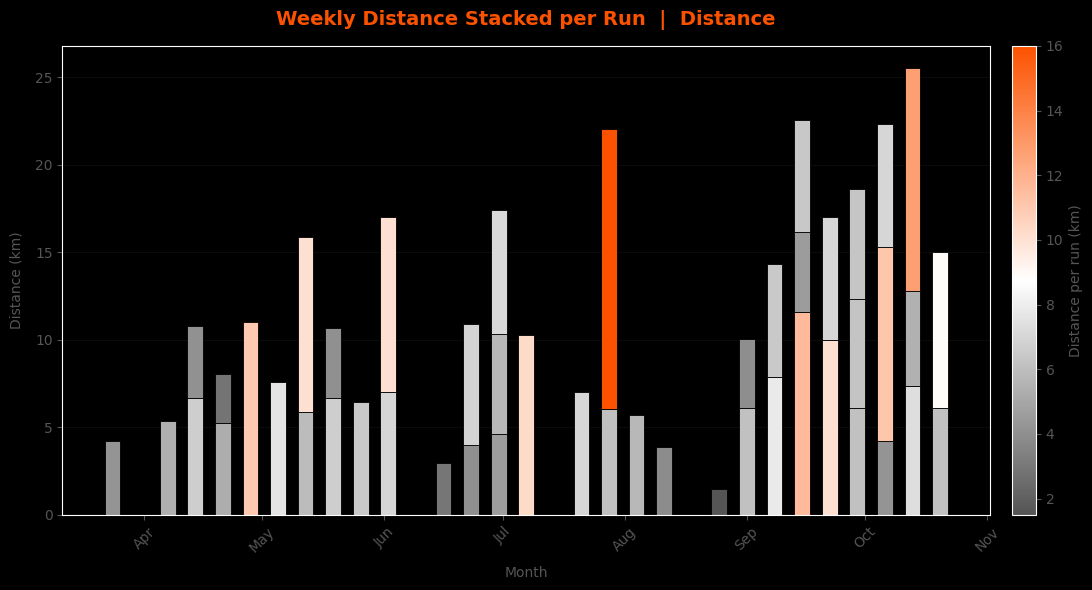

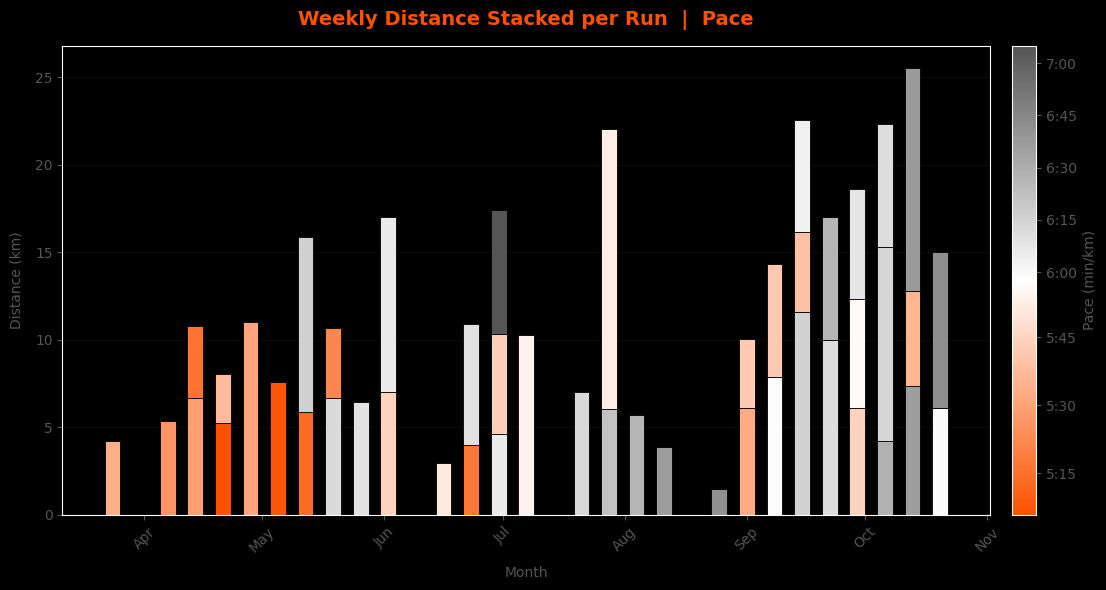

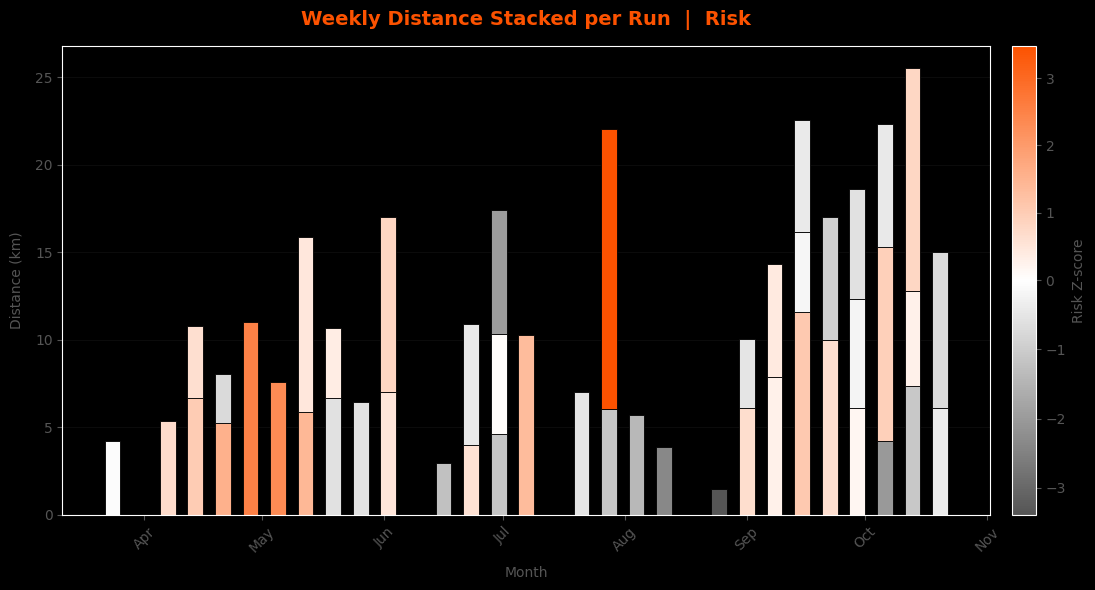

In [41]:
vis.plot_weekly(df_activities, col='distance')
vis.plot_weekly(df_activities, col='pace')
vis.plot_weekly(df_activities, col='risk')

# Weekly targets

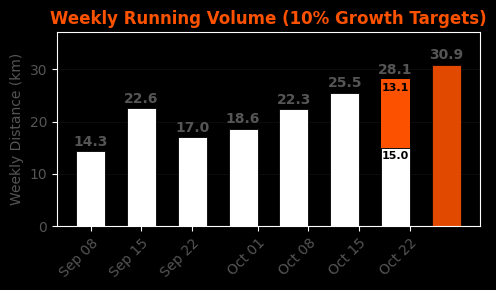

In [42]:
vis.plot_weekly_distance_targets(df_activities)

# Example week plans

In [43]:
week_target = 28.1

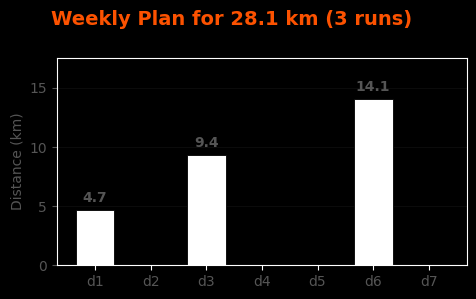

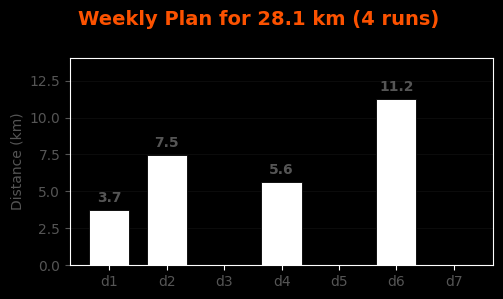

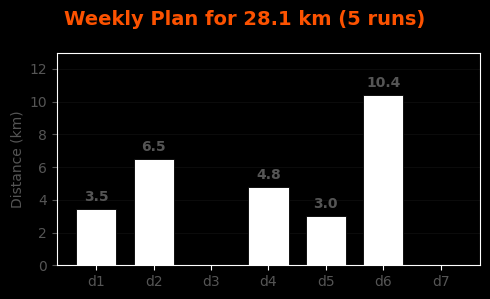

In [44]:
for runs in [3, 4, 5]:
    vis.plot_week_plan(week_target, runs)

# Proposed week plans given current week's runs

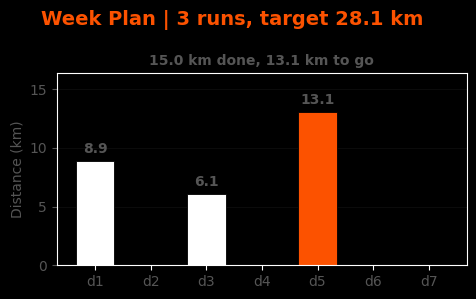

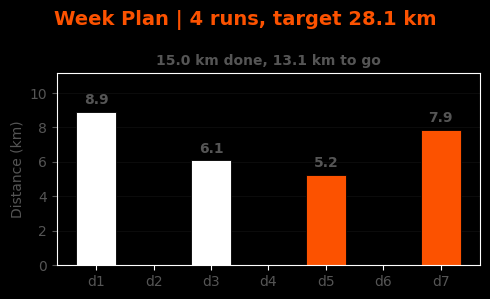

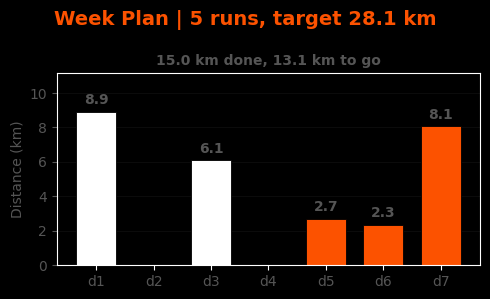

In [45]:
for runs in [3, 4, 5]:
    vis.plot_current_week_plan(df_activities, week_target, runs=runs, exclude_today=False)